# stitching.ipynb
__Author:__ Matthew Lesko-Krleza 260692352<br>
__Course:__ ECSE 415 Intro to Computer Vision<br>
__Deliverable:__ Assignment #2<br>
__Description:__ This notebook details the technical steps required for making a panorama. The example shown uses 3 pictures of a hill taken from the same position at different angles.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read all images used for this notebook
img_1hill = cv2.imread('stitching_images/1Hill.JPG')
img_2hill = cv2.imread('stitching_images/2Hill.JPG')
img_3hill = cv2.imread('stitching_images/3Hill.JPG')

# Convert to RGB otherwise you get the wrong colors of the image
img_1hill = cv2.cvtColor(img_1hill, cv2.COLOR_BGR2RGB)
img_2hill = cv2.cvtColor(img_2hill, cv2.COLOR_BGR2RGB)
img_3hill = cv2.cvtColor(img_3hill, cv2.COLOR_BGR2RGB)

### 2.1 Coding Questions
#### Question 2.1.1

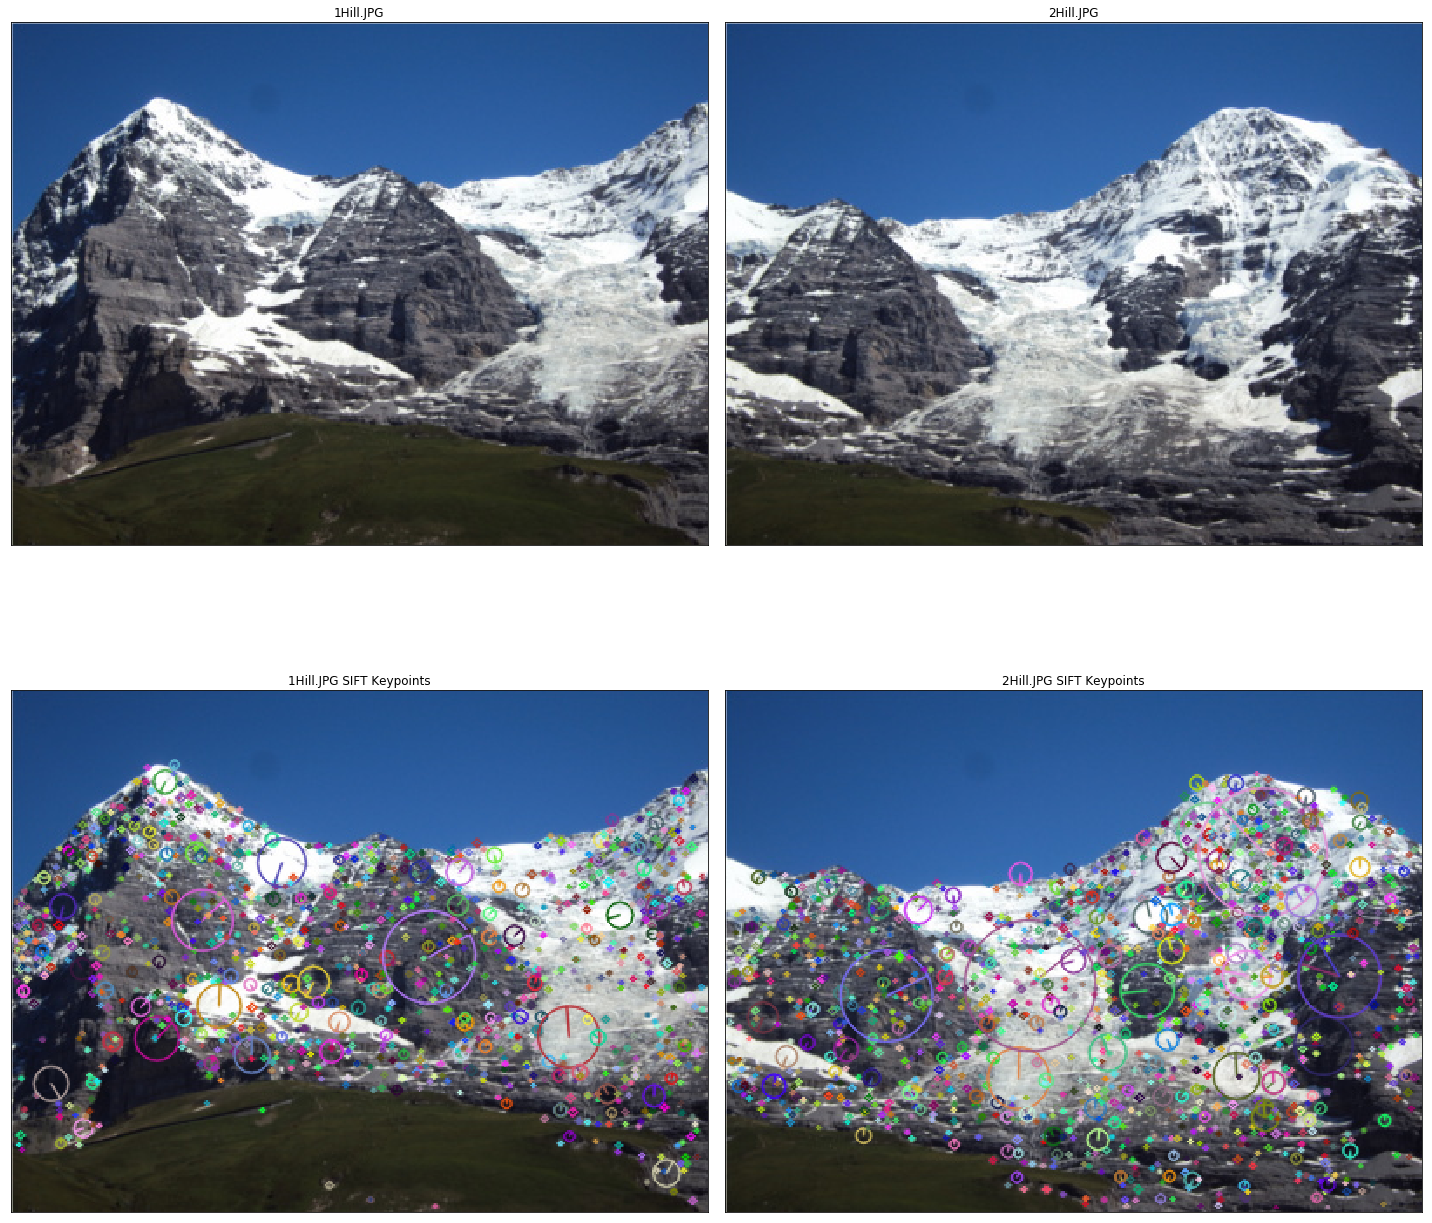

In [2]:
"""
This cell computes and displays SIFT keypoints and corresponding descriptors for images 1HILL and 2HILL.
"""
# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift_obj.detectAndCompute(img_1hill, None)
keypoints_2, descriptors_2 = sift_obj.detectAndCompute(img_2hill, None)

# Copy images so that original ones stay unchanged
img_1disp = img_1hill.copy()
img_2disp = img_2hill.copy()

# Draw the SIFT keypoints
cv2.drawKeypoints(img_1hill, 
                  keypoints_1, 
                  img_1disp, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_2hill,
                  keypoints_2, 
                  img_2disp, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img_1hill)
plt.title("1Hill.JPG"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img_2hill)
plt.title("2Hill.JPG"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_1disp)
plt.title("1Hill.JPG SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(img_2disp)
plt.title("2Hill.JPG SIFT Keypoints"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

#### Question 2.1.2

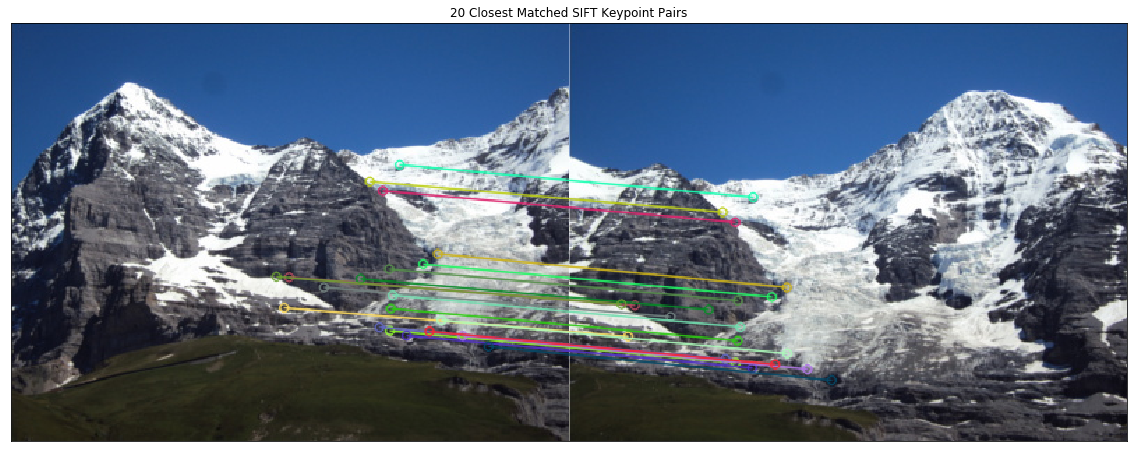

In [3]:
"""
This cell computes the matched SURF keypoint pairs in 1Hill and 2Hill and displays the 20 closest pairs.
"""
# Create BruteForceMatcher object
BF = cv2.BFMatcher()

# Match descriptors
matches = BF.match(descriptors_1, descriptors_2)

# Sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# Draw closest 20 matches
matched_12 = cv2.drawMatches(img_1hill,
                               keypoints_1,
                               img_2hill,
                               keypoints_2,
                               matches[:20],
                               img_1hill,
                               flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(matched_12)
plt.title("20 Closest Matched SIFT Keypoint Pairs"), plt.xticks([]), plt.yticks([])
plt.show()

#### Question 2.1.3

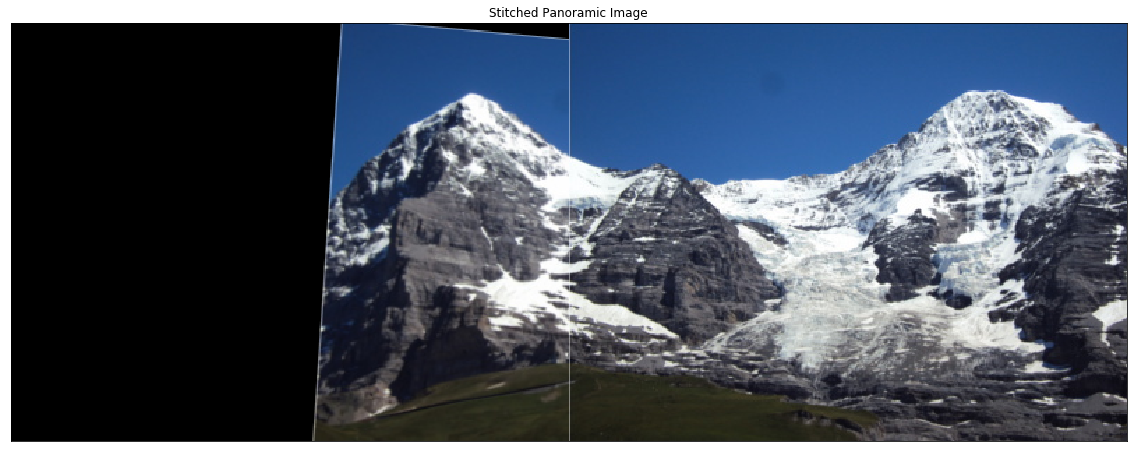

In [4]:
"""
This cell finds and displays the homography of 1Hill and 2Hill and the transformation on 1HILL.
"""
# Copy images as to avoid overwriting the original ones
img_1H = img_1hill.copy()
img_2H = img_2hill.copy()

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

# Match keypoints for the right and left images
# 2HILL is on the right (keypoints_2 -> right) and 1HILL is on the left (keypoints_1 -> left)
mpr = np.float32([keypoints_2[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints_1[i].pt for (__, i) in GoodMatches])

# Shift the right image's x-points because its pixels have to be shifted by img_2H.shape[1] to the right
for i in range(len(mpr)):
    mpr[i][0] += img_2H.shape[1]

# This adjusts the height
HEIGHT_BUFF = 0

# Used to move the transformed image downwards
M = np.float32([[1,0,0], [0,1,HEIGHT_BUFF], [0,0,1]]) 

# Find homography and apply the warp transform
H, __ = cv2.findHomography(mpl, mpr, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img_1H, 
                           M.dot(H), 
                           (img_2H.shape[1] + img_1H.shape[1], img_2H.shape[0] + 4 * HEIGHT_BUFF))

# Copy images for Question 2.1.4
img_left = wimg.copy()
img_right = np.zeros((img_2H.shape[0] + 4 * HEIGHT_BUFF, img_2H.shape[1] + img_1H.shape[1], 3), dtype = np.uint8)

img_right[HEIGHT_BUFF:img_2H.shape[0] + HEIGHT_BUFF, img_1H.shape[1]:,:] = img_2H
wimg[HEIGHT_BUFF:img_2H.shape[0] + HEIGHT_BUFF, img_1H.shape[1]:,:] = img_2H

plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(wimg)
plt.title("Stitched Panoramic Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Question 2.1.4

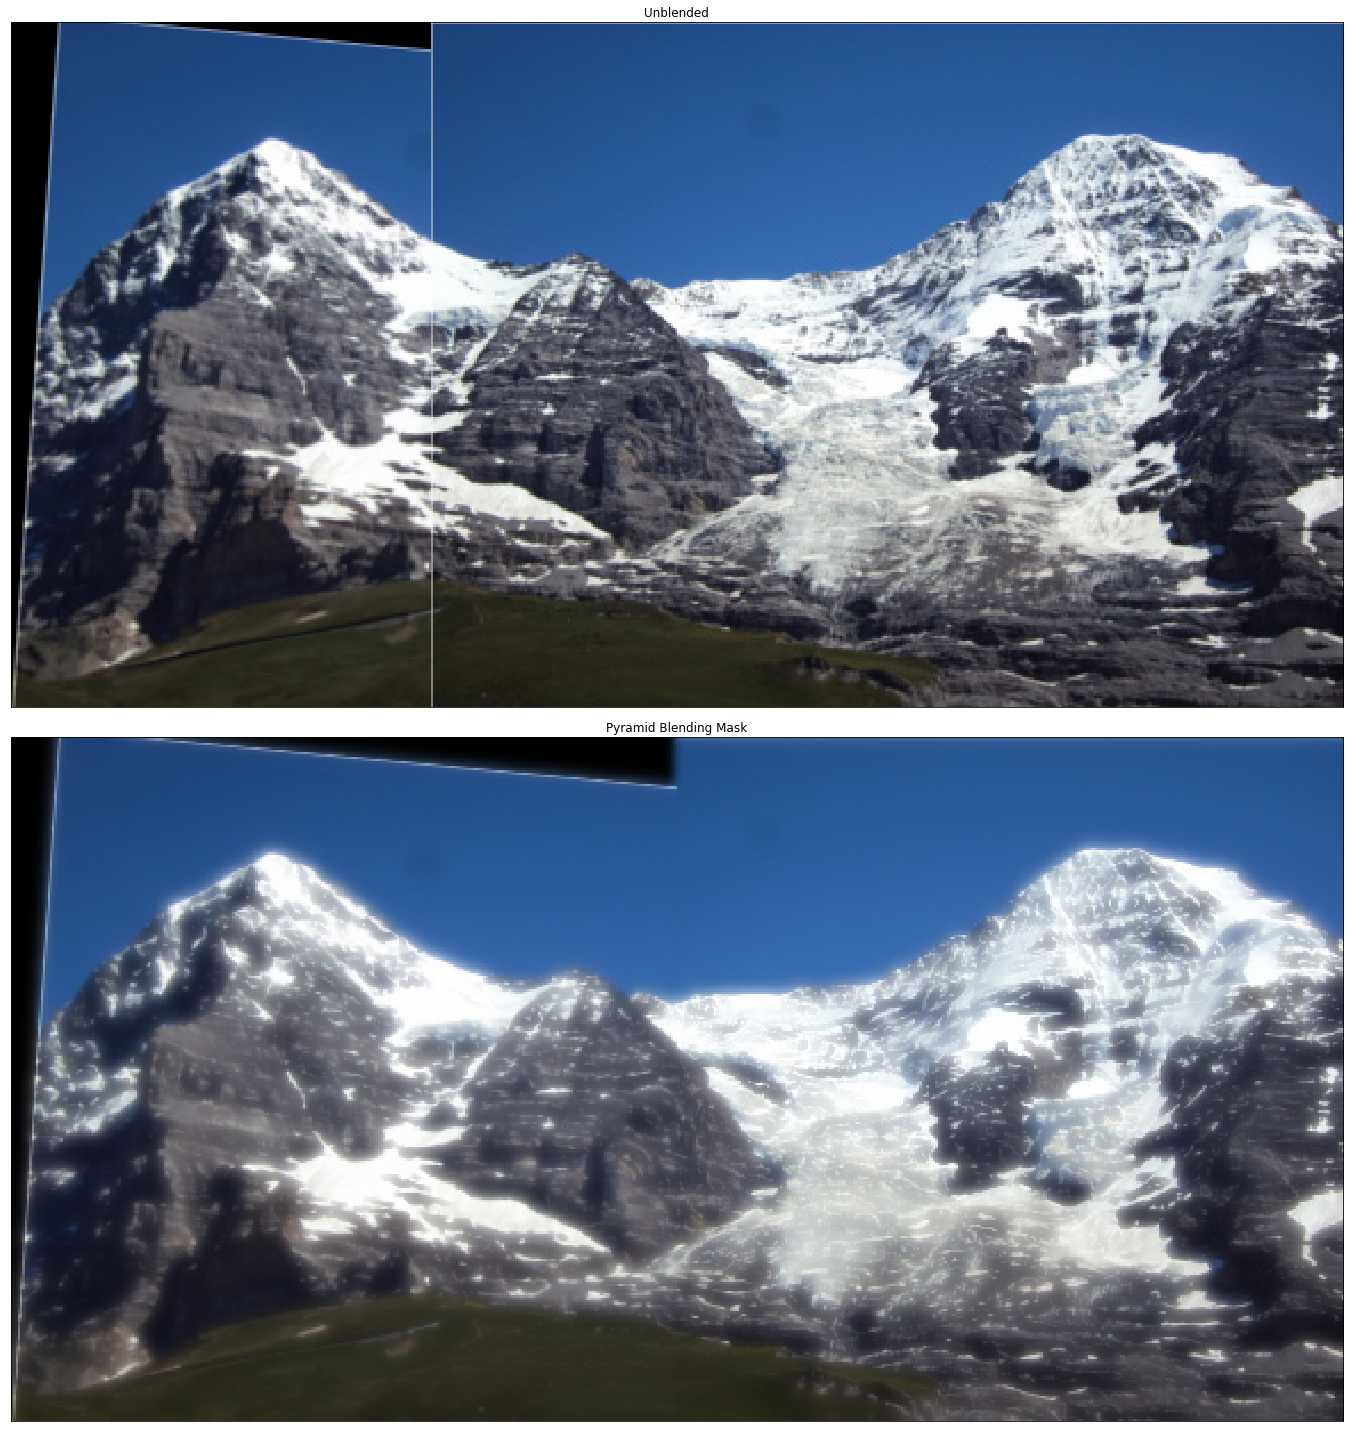

In [5]:
"""
This cell applies and displays pyramid image blending on the stitch transformed 1HILL image with the 2HILL image.
"""

def boundingRect(img):
    """Compute and return the up-right bounding rectangle of a point set"""
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret,thresholded = cv2.threshold(grayscale, 0, 255,cv2.THRESH_BINARY)
    return cv2.boundingRect(thresholded)

def computeGaussianPyramid(img, pyr_depth):
    """Compute the gaussian pyramid given an image and pyramid depth. Return list of gaussian pyramid layers."""
    layer = img.copy()
    pyr_gauss = [layer]
    for i in range(pyr_depth):
        layer = cv2.pyrDown(layer)
        pyr_gauss.append(layer)
    return pyr_gauss

def computeLaplacianPyramid(pyr_gauss, pyr_depth):
    """Compute the laplacian pyramid given a gaussian pyramid and pyramid depth. Return list of laplacian pyramid layers."""
    layer = pyr_gauss[pyr_depth-1]
    pyr_lap = [layer]
    for i in range(pyr_depth-1, 0, -1):
        size = (pyr_gauss[i - 1].shape[1], pyr_gauss[i - 1].shape[0])
        gauss_expanded = cv2.pyrUp(pyr_gauss[i], dstsize=size)
        laplacian = cv2.subtract(pyr_gauss[i - 1], gauss_expanded)
        pyr_lap.append(laplacian)
    return pyr_lap

# Pyramid depth parameter
PYR_DEPTH = 3

# Copy images to avoid overwriting
img_A = img_left.copy()
img_B = img_right.copy()

# Left clip
xLeft = boundingRect(img_A)[0]
img_A = img_A[:,xLeft:]
img_B = img_B[:,xLeft:]

# Determine dimensions
height, width, depth = img_B.shape
x, y, width, height = boundingRect(img_B)

# Create a img_real image before blending
img_real = img_A.copy()
img_real[y:y+height, x:x+width] = img_B[y:y+height, x:x+width]

# Gaussian Pyramid 1 and 2 for img_A and img_B respectively
pyr_gauss_1 = computeGaussianPyramid(img_A, PYR_DEPTH)
pyr_gauss_2 = computeGaussianPyramid(img_B, PYR_DEPTH)

# Compute Laplacian Pyramid 1 and 2 for img_A and img_B respectively
pyr_lap_1 = computeLaplacianPyramid(pyr_gauss_1, PYR_DEPTH)
pyr_lap_2 = computeLaplacianPyramid(pyr_gauss_2, PYR_DEPTH)

# Merge of laplacian pyramids
pyr_mountain = []
n = 0
for img_A_lap, img_B_lap in zip(pyr_lap_1, pyr_lap_2):
    n += 1
    cols, rows, ch = img_A_lap.shape
    laplacian = img_A_lap.copy()
    laplacian = np.hstack((img_A_lap[:, 0:int(rows/2)], img_B_lap[:, int(rows/2):]))
    pyr_mountain.append(laplacian)
    
# Reconstruct photo
img_reconstruct = pyr_mountain[0]
for i in range(1, PYR_DEPTH):
    size = (pyr_mountain[i].shape[1], pyr_mountain[i].shape[0])
    img_reconstruct = cv2.pyrUp(img_reconstruct, dstsize=size)
    img_reconstruct = cv2.add(pyr_mountain[i], img_reconstruct)

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(img_real)
plt.title("Unblended"), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(img_reconstruct)
plt.title("Pyramid Blending Mask"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

#### Question 2.1.5

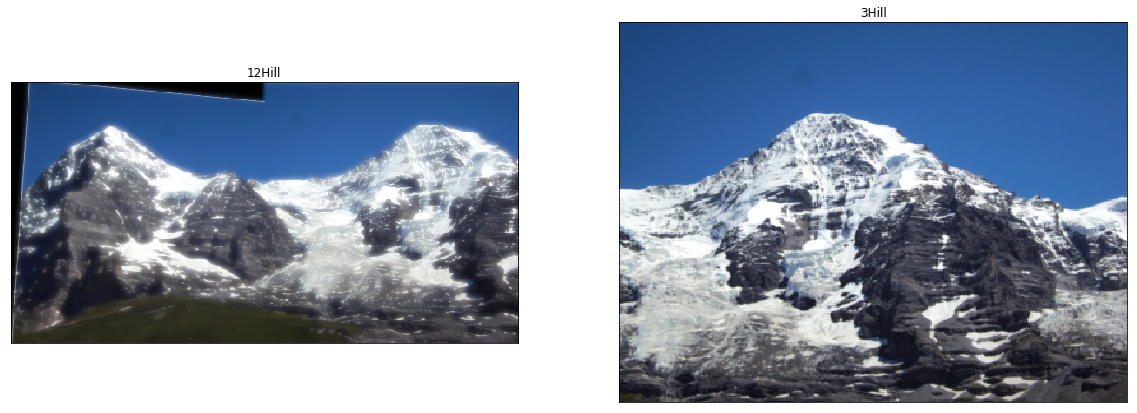

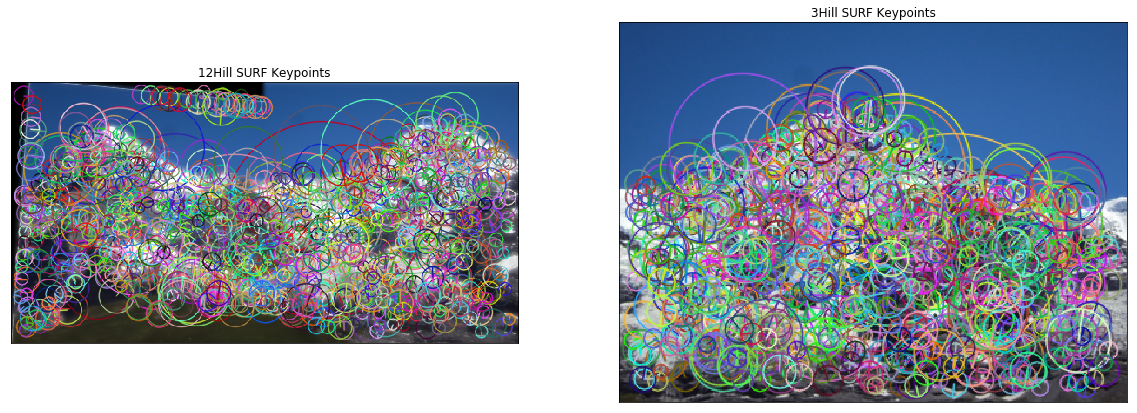

In [6]:
"""
This cell computes and displays the SURF keypoints and corresponding descriptors for images 12Hill and 3Hill.
"""
# Copy image for use in this cell
img_12hill = img_reconstruct.copy()

CROP_VALUE = 1;
img_3hill =img_3hill[CROP_VALUE:img_3hill.shape[0]-CROP_VALUE, CROP_VALUE:img_3hill.shape[1]-CROP_VALUE]

# Create copies for displaying
img_12disp = img_12hill.copy()
img_3disp = img_3hill.copy()

# Create SURF object
surf_obj = cv2.xfeatures2d.SURF_create()

# Detect and compute surf keypoints and descriptors
keypoints_12, descriptors_12 = surf_obj.detectAndCompute(img_12hill, None)
keypoints_3, descriptors_3 = surf_obj.detectAndCompute(img_3hill, None)

# Draw surf keypoints on the img_12disp and img_3disp images
cv2.drawKeypoints(img_12hill, keypoints_12, img_12disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_3hill, keypoints_3, img_3disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(img_12hill)
plt.title("12Hill"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img_3hill)
plt.title("3Hill"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(20,20))
plt.subplot(223), plt.imshow(img_12disp)
plt.title("12Hill SURF Keypoints"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(img_3disp)
plt.title("3Hill SURF Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

#### Question 2.1.6

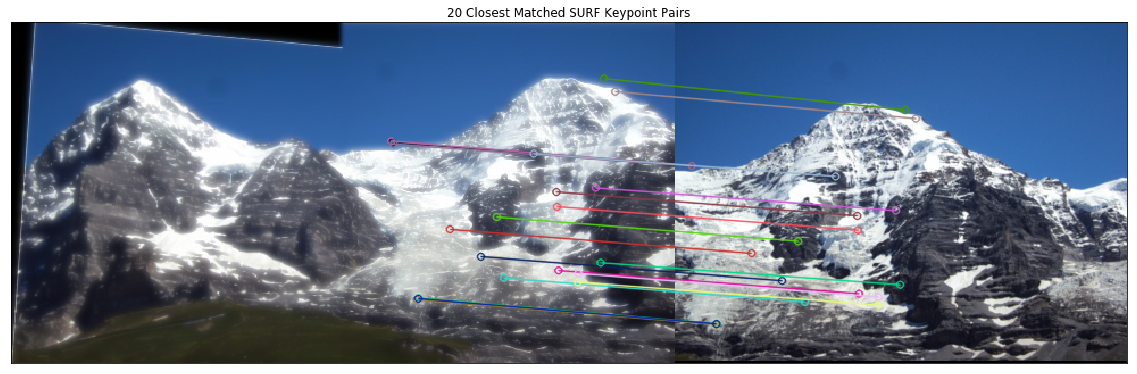

In [7]:
"""
This cell computes the matched SURF keypoint pairs in 12Hill and 3Hill and displays the 20 closest pairs.
"""
# BruteForceMatcher object
BF = cv2.BFMatcher()

# Match descriptors
matches = BF.match(descriptors_12, descriptors_3)

# Sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# Draw the first 20 matched pairs
matched_123 = cv2.drawMatches(img_12hill,
                              keypoints_12,
                              img_3hill,
                              keypoints_3, 
                              matches[:20], 
                              img_12hill, 
                              flags=2)

plt.figure(figsize=(20, 20))
plt.imshow(matched_123)
plt.title("20 Closest Matched SURF Keypoint Pairs"), plt.xticks([]), plt.yticks([])
plt.show()

#### Question 2.1.7

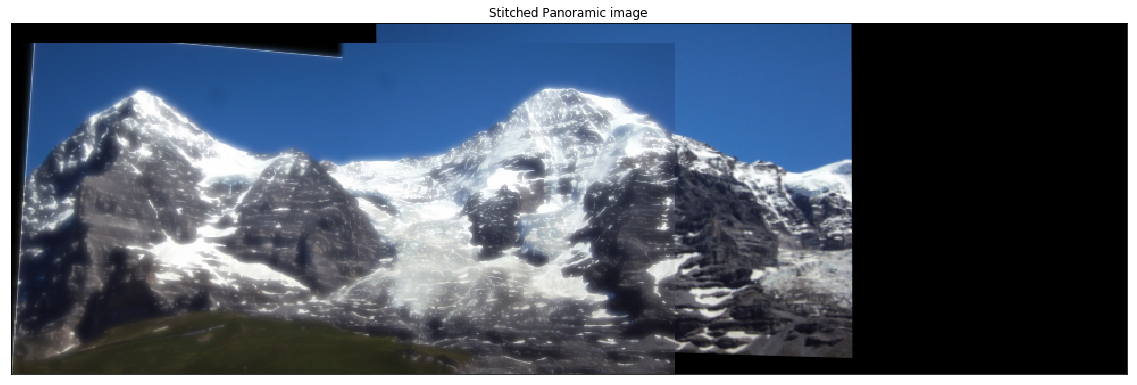

In [8]:
# Create copy of 12Hill and 3Hill as to not overwrite them
img_12H = img_12hill.copy()
img_3H = img_3hill.copy()

# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

# Match keypoints for the right and left images
# 3Hill is on the right (keypoints_3 -> right) and 12Hill is on the left (keypoints_12 -> left)
mpr = np.float32([keypoints_3[i].pt for (i, __) in GoodMatches])
mpl = np.float32([keypoints_12[i].pt for (__, i) in GoodMatches])

# Shift the right image's x-points because its pixels have to be shifted by img_12H.shape[1] to the right
for i in range(len(mpr)):
    mpr[i][0] += img_12H.shape[1]

# This is used to shift an image downwards as to not have it clipped
HEIGHT_BUFF = 9

# This moves the warped right image downwards by a factor of HEIGHT_BUFF
M = np.float32([[1, 0, 0], [0, 1, HEIGHT_BUFF], [0, 0, 1]])

# This is used to right shift the 3Hill image by a factor of img_12H.shape[1]
N = np.float32([[1, 0, img_12H.shape[1]], [0, 1, 0], [0, 0, 1]]) 

# Compute homography and transform image
H, __ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)
wimg = cv2.warpPerspective(img_3H, 
                            M.dot(H.dot(N)), 
                            (img_3H.shape[1] + img_12H.shape[1], img_12H.shape[0] + HEIGHT_BUFF))

# This saves the images for use in later cells
img_right = wimg.copy()
img_left = np.zeros((img_12H.shape[0] + HEIGHT_BUFF, img_12H.shape[1] + img_3H.shape[1], 3), dtype=np.uint8)

img_left[HEIGHT_BUFF : img_12H.shape[0] + HEIGHT_BUFF, : img_12H.shape[1], :] = img_12H
wimg[2 * HEIGHT_BUFF : img_12H.shape[0] + HEIGHT_BUFF, : img_12H.shape[1], :] = img_12H[HEIGHT_BUFF : , : , :]
    
plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(wimg)
plt.title("Stitched Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Question 2.1.8

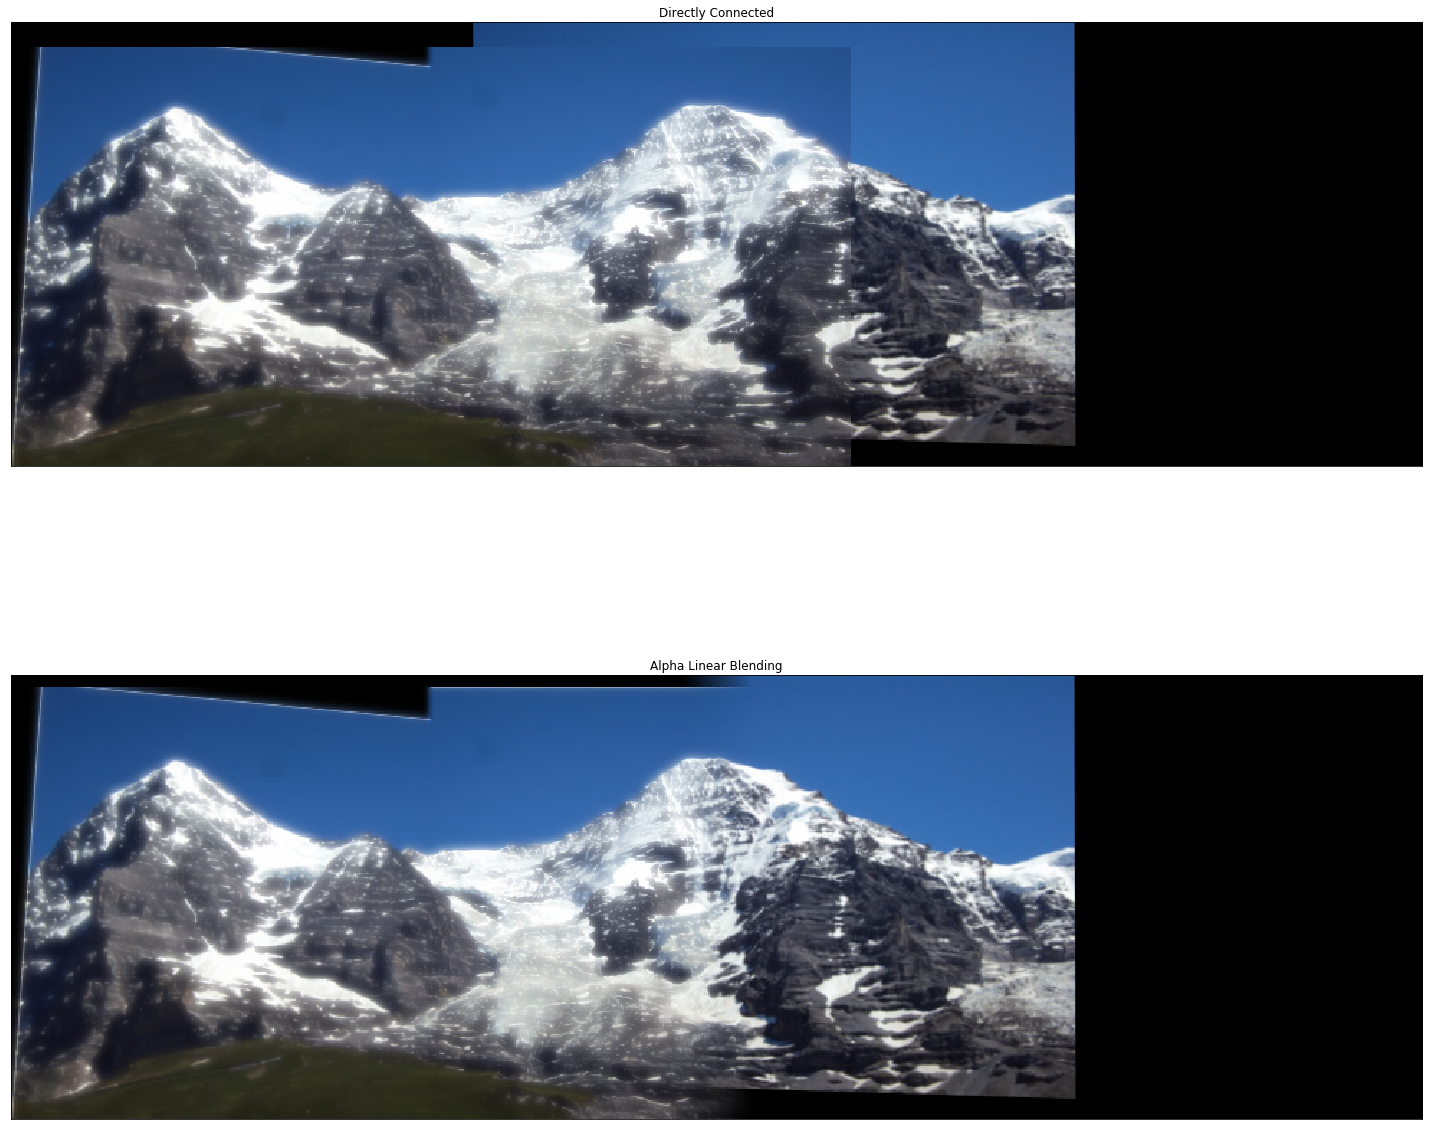

In [9]:
"""
This cell applies and displays linear image blending to the stitched transformed 3Hill and 12Hill images.
"""
img_A = img_left.copy()
img_B = img_right.copy()

# Determine height, width
height, width = img_A.shape[0:2]
# image with direct connecting each half
real = np.hstack((img_A[:, :round(height / 2)], img_B[:, round(height / 2):]))

""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# Alpha blending ramp
RAMP_SIZE = 50
alpha = Ramp(img_A.shape[1], RAMP_SIZE, round(img_A.shape[1] / 2), 0, 1)

# Now blend
I_blend = (1 - alpha.reshape(1, -1, 1)) * img_A + alpha.reshape(1, -1, 1) * img_B
I_blend = np.uint8(I_blend)

plt.figure(figsize=(20, 20))
plt.subplot(211), plt.imshow(wimg)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(I_blend)
plt.title("Alpha Linear Blending"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

#### 2.2 Reasoning Questions
##### Question 1: 
SURF is claimed and was designed to be 3 to 6 times faster than SIFT by using what is called the Fast-Hessian detector. However, SURF is claimed to be less robust to illumination and viewpoint changes compared to SIFT. The main difference in computation is that SIFT computes a pyramid of DoG or Laplacian images for the image at different octects. Whereas SURF computes the integrals of an image and calculates the determinant of those integrals which yields an approximation to the SIFT features. As one can see in the cell below, for the same image, SIFT generates a larger amount of keypoints, making it more robust.
##### Question 2:
The pro of using linear blending over pyramid blending is that it is less computationaly heavy compared to pyramid blending. Linear blending takes the average of two overlaid textures over a window defined by a ramp and width. The con of using linear blending is that ghosting effects can occur often, especially when a larger window is used for the blending. The pro of pyramid blending is that it reduces the amount of ghosting while also blending two images. The con is that it is more computationaly heavy, because it needs to compute the Laplacian pyramid of the image and either blend slowly at low frequencies or quickly at higher frequencies.
One should prefer using pyramid blending over linear blending when there are large amounts of both low and high frequency variations in the images. Using a static window to blend the images would create a significant amount of ghosting. Therefore, a pyramid blending scheme is prefered.
##### Question 3:
If that were the case, one would have to determine a consensus with estimating the homography given the random subset of matching keypoint pairs. With a minimum subset of data randomly chosen, a transformational model is proposed and evaluated with a permissible error (neglecting outliers). This process is evaluated after a number of subsets has been chosen and the model with the maximum number of inliers is used to approximate the homography.
The process is computed as follows. First, a random subset is chosen from the samples, and a homography is computed given the pairs. Secondly, points would be projected from the first image to the second and the number of inliers (points) would be counted within a given threshold determined by the computed homography line. A consensus would be made with the line containing the largest amount of inliers; disregard the outliers. The match with the largest inliers would be used to compute the "average" translation vector. Finally, using the average translation vector, a translation can be performed.
##### Question 4:
Given a small amount of matching keypoint pairs  between two images, inferring a homography is more prone to error because erronous matching keypoint pairs have a greater effect on homography approximation (one error has a large effect if there are only 10 inliers chosen for the homography computation). As opposed to a large amount of matching keypoint pairs, there is a larger amount of non-erronous matching keypoint pairs which aids in providing a more accurate homography, by having erronous matching keypoint pairs having less effect on the homography computation (one error has less effect if there are 100 inliers chosen for the homography computation).

In [109]:
sift_kp1, sift_desc1 = sift_obj.detectAndCompute(img_1hill, None)
surf_kp1, surf_desc1 = surf_obj.detectAndCompute(img_1hill, None)
print(str.format('Number of SIFT Keypoints: {}', len(sift_kp1)))
print(str.format('Number of SURF Keypoints: {}', len(surf_kp1)))

Number of SIFT Keypoints: 1217
Number of SURF Keypoints: 891
